# Import and configure the lib

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


# Dataset to be load

In [49]:
data = pd.read_csv(r'C:\Users\vaish\Downloads\TitanicDataset.csv')


print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


# Exploration of data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


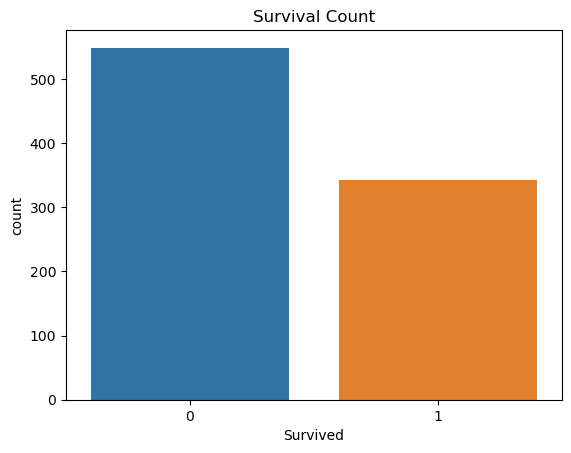

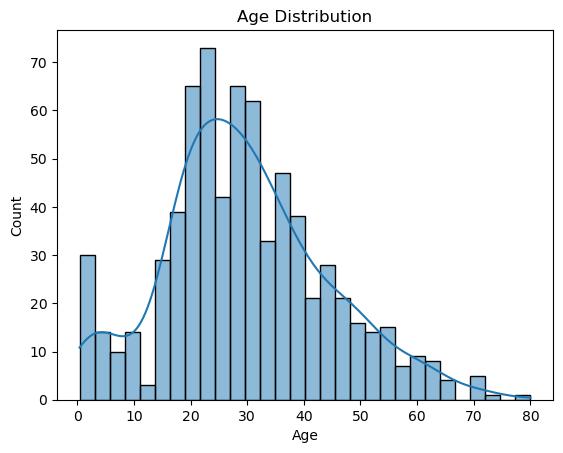

In [50]:

print(data.isnull().sum())


sns.countplot(x='Survived', data=data)
plt.title('Survival Count')
plt.show()


sns.histplot(data['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Stratified Shuffle Split for Data Splitting


In [51]:
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(data, data[["Survived","Pclass","Sex"]]):
    strat_train_set= data.loc[train_indices]
    strat_test_set= data.loc[test_indices]
    
    strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 169 to 379
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          576 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        160 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


# Imputer: Handling Missing Values

In [58]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age']= imputer.fit_transform(X[['Age']])
        return X

# Feature Encounter: Handling Feature Interactions

In [59]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder= OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
             
            matrix = encoder.fit_transform(X[['Sex']]).toarray()
            
            column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X

# Feature Dropper: Removing Irrelevant Features

In [60]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Emabarked", "Name","Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [55]:
pipeline = Pipeline([("ageimputer", AgeImputer()),
                    ("featureencoder", FeatureEncoder() ),
                    ("featuredropper", FeatureDropper())])

In [62]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 169 to 379
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          576 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        160 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


# Preprocessing of data

In [13]:

data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])


data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)


X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the train and test data

In [14]:
# Split the data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model

In [15]:

model = RandomForestClassifier(n_estimators=100, random_state=42)


model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#  Predictions of data

In [16]:

y_pred = model.predict(X_test)

# Evaluate the model

In [17]:


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[91 14]
 [18 56]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



# Display Feature Importance

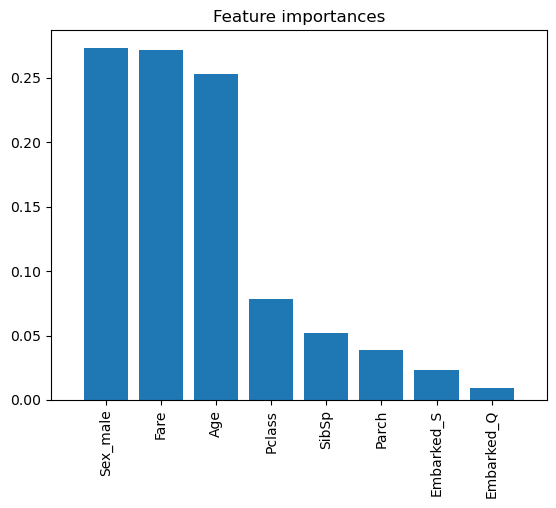

In [18]:

importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Accuracy

In [19]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.82


# Cross-Validation

In [20]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")

Cross-Validation Scores: [0.79888268 0.81460674 0.84831461 0.78651685 0.82022472]
Mean CV Score: 0.81


# "ROC Curve" and "AUC"

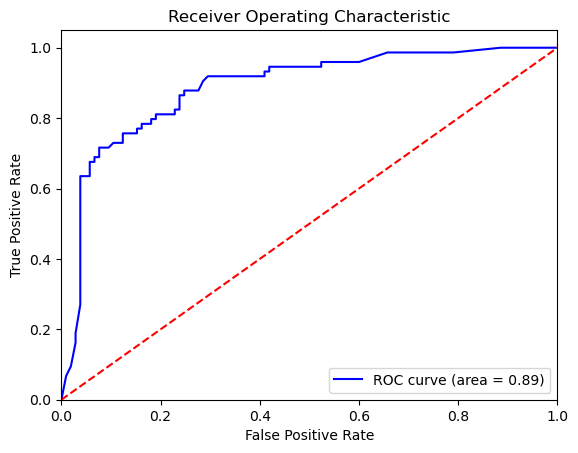

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_prob = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# #THANKYOU 